In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

Below is the outline for this notebook:
* <a href='#load'>Load the Data</a>
* <a href='#first'>First Iteration of E Step and M Step</a>
* <a href='#second'>Second Iteration of E Step and M Step</a>
* <a href='#third'>Third Iteration of E Step and M Step</a>
* <a href='#general'>The Iterative Process</a>
* <a href='#business'>Additional Analysis of Clusters and Business Findings</a>
* <a href='#other'>Other Applications</a>
* <a href='#sources'>Sources</a>

# Load the Data <a id='load'></a>

The synthesized dataset contains both information on marketing newsletters/e-mail campaigns (e-mail offers sent) and transaction level data from customers (which offer customers responded to and what they bought).

The marketing campaign focused on two aspects of an insurance product: amount of premium savings the customer can receive if he/she chooses the product, and the closeness and accessibility to an insurance agent in the same neighborhood.  The level of focuses on each of the aspect is ranked from 0 to 10.

In [4]:
df_offers = pd.read_excel("./Insurance Product Offering.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "product_type", "level_emphasis_premium_savings", \
                     "level_emphasis_neighborhood_agent"]
df_offers.head()

,offer_id,campaign,product_type,level_emphasis_premium_savings,level_emphasis_neighborhood_agent
0,1,January,Product 1,7,5
1,2,January,Product 2,7,1
2,3,February,Product 3,10,3
3,4,February,Product 4,7,4
4,5,February,Product 5,10,4


The responses tab in the spreadsheet shows which offer the customer responded to or expressed interest in.  In addition to the customer_name and offer_id columns that come with the spreadsheet, we also added a column 'n' that is always 1.

In [7]:
df_responses = pd.read_excel("./Insurance Product Offering.xlsx", sheetname=1)
df_responses.columns = ["customer_name", "offer_id"]
df_responses['n'] = 1
df_responses.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [8]:
# join the offers and responses tables
df = pd.merge(df_offers, df_responses)
df.head()

,offer_id,campaign,product_type,level_emphasis_premium_savings,level_emphasis_neighborhood_agent,customer_name,n
0,1,January,Product 1,7,5,Thomas,1
1,1,January,Product 1,7,5,Jackson,1
2,1,January,Product 1,7,5,Mitchell,1
3,1,January,Product 1,7,5,Peterson,1
4,1,January,Product 1,7,5,Wood,1


In [9]:
# create a "pivot table" which will give us the number of times each customer responded to a given offer
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
print matrix

offer_id        1    2    3    4    5    6    7    8    9    10 ...    23  \
customer_name                                                   ...         
Adams          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN   
Allen          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN ...   NaN   
Anderson       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN   
Bailey         NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN ...   NaN   
Baker          NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  1.0 ...   NaN   
Barnes         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0 ...   NaN   
Bell           NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN   
Bennett        NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN ...   NaN   
Brooks         NaN  NaN  1.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN ...   NaN   
Brown          NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN ...   NaN   
Butler         1.0  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN   

In [10]:
# fill NA values with 0 and make the index into a column
matrix = matrix.fillna(0).reset_index()
print matrix

offer_id customer_name    1    2    3    4    5    6    7    8    9 ...    23  \
0                Adams  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
1                Allen  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 ...   0.0   
2             Anderson  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
3               Bailey  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
4                Baker  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
5               Barnes  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
6                 Bell  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
7              Bennett  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0   
8               Brooks  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0   
9                Brown  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
10              Butler  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
11            Campbell  0.0 

In [11]:
# save a list of the 0/1 columns (offer id). we'll use these a bit later
x_cols = matrix.columns[1:]
print x_cols

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name=u'offer_id')


In [12]:
data = matrix[x_cols]

In [13]:
data = data.as_matrix()

In [14]:
print data

[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  1.]]


# Below is code for Gaussian Mixture Models with Expectation-Maximization:

In [15]:
def mv_normal_log_pdf(X, mu, Sig):
    return (-0.5*np.linalg.slogdet(2*np.pi*Sig)[1]
     - 0.5*np.sum((X-mu)*(np.linalg.inv(Sig).dot((X-mu).T)).T,axis=1))

In [16]:
class GaussianMixture:
    def init_parameters(self, X, P, k, reg):
        """ Initialize the parameters of means, covariances, and frequency counts. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                P (numpy 2D matrix) : Random permutation vector
                k (float) : number of clusters
                reg (float) : regularization parameter for the covariance matrix
            Returns: 
                mus (numpy 2D matrix) : matrix of initialzied means, chosen randomly by selection the first k elements of P
                Sigmas (list) : list of 2D covariance matrices corresponding to each cluster
                phi (numpy 1D vector) : vector of initialized frequencies
        """
        # initlize the centers mu. each row of the matrix is a center
        # we use the first k random indices of the permutation as centers
        mu_index = P[:k]  
        Mu = X[mu_index,:]
        
        #Covariance matrix should be intialized as the sample covariance of the 
        #entire data matrix plus regularization using the unbiased estimater. 
        sigma = np.cov(X.T + reg)
        sigmas =[sigma] * k  #list of 2D covariance matrices corresponding to each cluster/component
        
        # start with equal probability for all the clusters/gaussian components
        phi = np.empty(k)  
        phi.fill(1.0/float(k))
        return Mu, sigmas, phi
        
        

    def Estep(self, X, mus, Sigmas, phi):
        """ Perform an E step and return the resulting probabilities. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                mus (numpy 2D matrix) : matrix of initialzied means, chosen randomly by selection the first k elements of P
                Sigmas (list) : list of 2D covariance matrices corresponding to each cluster
                phi (numpy 1D vector) : vector of initialized frequencies
            Returns: 
                (numpy 2D matrix) : matrix of probabilities, where the i,jth entry corresponds to the probability of the
                                    ith element being in the jth cluster. 
        """
        # matrix of probabilities. where the i,jth entry corresponds to the probability of the ith element being in
        # jth cluster/component
        mx_prob = np.zeros((X.shape[0],len(Sigmas)))
        for j in range(mx_prob.shape[1]):
            # multivariate normal log pdf function
            mx_prob[:,j] = mv_normal_log_pdf(X, mus[j, :], Sigmas[j]) + np.log(phi[j])
        #log trick: dividing by a very large negative number can cause numerical problems, since everything is 0
        # so we add a small number to numerator and denominator before division
        # it is common to use the row max so at least one element in the resulting probability vector is 1
        log_trick = np.max(mx_prob,axis=1)
        mx_prob = np.exp(mx_prob-log_trick[:, np.newaxis])
        mx_prob = mx_prob/np.sum(mx_prob, axis=1)[:,None]
        
        return mx_prob
        

    def Mstep(self, ps, X, reg):
        """  
            Args: 
                ps (numpy 2D matrix) : matrix of probabilities, where the i,jth entry corresponds to the probability of the
                                       ith element being in the jth cluster. 
                X (numpy 2D matrix) : data matrix, each row is an example
                reg (float) : regularization parameter for the covariance matrix
            Returns: 
                (mus, Sigmas, phi) : 3 tuple of matrix of initialzied means, chosen randomly by selection the first 
                                     k elements of P, a list of 2D covariance matrices corresponding to each cluster, 
                                     and a vector of initialized frequencies
        """
        # sum up the probability of being in jth cluster (column sum), divided by number of rows in ps (num of records)
        phi = np.sum(ps, axis = 0)/float(ps.shape[0])
        # ps transpose dot X, divided by column sum of ps
        mus = ps.T.dot(X)/ np.sum(ps, axis=0)[:, None]

        Sigmas = []
        for k in range(ps.shape[1]):  # for each cluster
            step0 = X - mus[k,:]
            step1 = step0.T*(ps[:, k]) #step0 is m by n, step0.T is n by m, ps[:,k] is m by 1 so its matrix vector multi
                                       # step1 is n by m
            step2 = step1.dot(step0)   #step2 is n by n
            step3 = step2/float(np.sum(ps[:,k])) #n by n
            # add covariance matrix regulaization
            sigma = step3 + np.eye(step3.shape[1])*reg
            #append to the list of covariance matrices
            Sigmas.append(sigma)
        return (mus, Sigmas, phi)
        
        
        
        
            
    
    def train(self, X, mus, Sigmas, phi, niters = 5, reg=1e-4):
        """ Train the model using the EM algorithm for a number of iterations. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                mus (numpy 2D matrix) : matrix of initialzied means, chosen randomly by selection the first k elements of P
                Sigmas (list) : list of 2D covariance matrices corresponding to each cluster
                phi (numpy 1D vector) : vector of initialized frequencies
                niters (int) : number of EM iterations to run
            Returns: 
                (mus, Sigmas, phi) : 3 tuple of matrix of initialzied means, chosen randomly by selection the first 
                                     k elements of P, a list of 2D covariance matrices corresponding to each cluster, 
                                     and a vector of initialized frequencies 
        
        """
        for i in range(niters):
            mx_prob = self.Estep(X, mus, Sigmas, phi)
            mus, Sigmas, phi = self.Mstep(mx_prob, X, reg)
        return (mus, Sigmas, phi)


# First Iteration of E Step and M Step <a id='first'></a>

In [22]:
k = 4
P = np.arange(data.shape[0])
reg = 1e-4
GM = GaussianMixture()
mus, Sigmas, phi = GM.init_parameters(data, P, k, reg)
ps = GM.Estep(data, mus, Sigmas, phi)
mus, Sigmas, phi = GM.Mstep(ps, data, reg)

In [23]:
print ps.shape
print ps

(100L, 4L)
[[  9.99999990e-01   4.05863200e-11   3.67828247e-10   9.96181043e-09]
 [  4.05863204e-11   1.00000000e+00   3.09779961e-13   1.30994511e-10]
 [  3.67828249e-10   3.09779960e-13   9.99999996e-01   3.98434711e-09]
 [  9.96181040e-09   1.30994510e-10   3.98434707e-09   9.99999986e-01]
 [  6.92564519e-02   2.19319521e-04   1.27255468e-03   9.29251674e-01]
 [  2.25848511e-02   1.09691924e-03   2.20559792e-02   9.54262251e-01]
 [  4.96718820e-01   6.44504569e-04   2.79773491e-04   5.02356902e-01]
 [  9.94175231e-01   7.54787312e-05   4.94678377e-03   8.02506377e-04]
 [  3.82245940e-01   3.23691600e-04   2.73633235e-01   3.43797133e-01]
 [  1.02636265e-02   5.35096169e-08   2.18641253e-06   9.89734134e-01]
 [  1.45195876e-02   2.55144438e-07   6.21095869e-03   9.79269199e-01]
 [  4.60063900e-06   8.30738843e-09   9.99989857e-01   5.53440056e-06]
 [  5.38674924e-03   5.85257089e-06   1.70884034e-04   9.94436514e-01]
 [  2.45758497e-02   1.38599395e-06   7.47002710e-02   9.00722493e

In [24]:
cluster_1 = np.argmax(ps, axis = 1) #in the actual function, a data point contributes to recomputing the parameters of
                                    # every single Guassian component it can potentially belong to

In [25]:
matrix['cluster_1'] = cluster_1

# To visualize the cluster, we performed a dimension reduction:

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['customer_name', 'cluster_1', 'x', 'y']]
print customer_clusters

offer_id customer_name  cluster_1         x         y
0                Adams          0  1.007580  0.108215
1                Allen          1 -0.287539  0.044715
2             Anderson          2 -0.392032  1.038391
3               Bailey          3  0.699477 -0.022542
4                Baker          3  0.088183 -0.471695
5               Barnes          3 -0.485282 -0.725503
6                 Bell          3 -0.591941  1.506500
7              Bennett          0  0.661732  0.090308
8               Brooks          0 -0.118943 -0.577499
9                Brown          3  1.079827 -0.007488
10              Butler          3 -0.240431 -0.617026
11            Campbell          2 -0.522247  1.231406
12              Carter          3  1.260763 -0.014255
13               Clark          3 -0.579221 -0.420475
14             Collins          3  0.193998  0.010306
15                Cook          2 -0.392032  1.038391
16              Cooper          3 -0.406276 -0.045771
17                 Cox      

In [27]:
customer_clusters.cluster_1.value_counts()

3    60
0    28
1     7
2     5
Name: cluster_1, dtype: int64

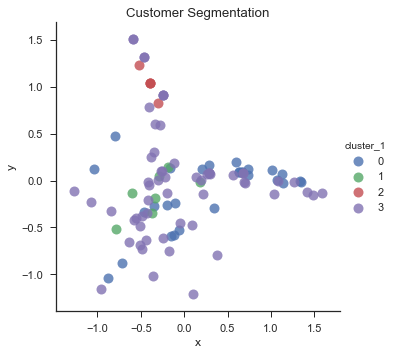

In [29]:
#https://chrisalbon.com/python/seaborn_scatterplot.html

sns.lmplot('x', 'y',
           data=customer_clusters,
           fit_reg=False,
           hue='cluster_1',  
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('Customer Segmentation')
plt.xlabel('x')
plt.ylabel('y')

# Second Iteration of E Step and M Step <a id='second'></a>

In [30]:
ps = GM.Estep(data, mus, Sigmas, phi)
mus, Sigmas, phi = GM.Mstep(ps, data, reg)

In [31]:
cluster_2 = np.argmax(ps, axis = 1)

In [32]:
matrix['cluster_2'] = cluster_2
customer_clusters = matrix[['customer_name', 'cluster_1','cluster_2', 'x', 'y']]
print customer_clusters

offer_id customer_name  cluster_1  cluster_2         x         y
0                Adams          0          0  1.007580  0.108215
1                Allen          1          1 -0.287539  0.044715
2             Anderson          2          2 -0.392032  1.038391
3               Bailey          3          0  0.699477 -0.022542
4                Baker          3          3  0.088183 -0.471695
5               Barnes          3          3 -0.485282 -0.725503
6                 Bell          3          2 -0.591941  1.506500
7              Bennett          0          0  0.661732  0.090308
8               Brooks          0          2 -0.118943 -0.577499
9                Brown          3          0  1.079827 -0.007488
10              Butler          3          3 -0.240431 -0.617026
11            Campbell          2          2 -0.522247  1.231406
12              Carter          3          0  1.260763 -0.014255
13               Clark          3          3 -0.579221 -0.420475
14             Collins   

In [33]:
customer_clusters.cluster_2.value_counts()

0    36
3    31
2    21
1    12
Name: cluster_2, dtype: int64

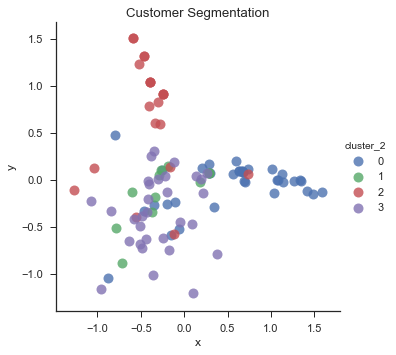

In [34]:
sns.lmplot('x', 'y',
           data=customer_clusters,
           fit_reg=False,
           hue='cluster_2',  
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('Customer Segmentation')
plt.xlabel('x')
plt.ylabel('y')

# Third Iteration of E Step and M Step <a id='third'></a>

In [35]:
ps = GM.Estep(data, mus, Sigmas, phi)
mus, Sigmas, phi = GM.Mstep(ps, data, reg)
cluster_3 = np.argmax(ps, axis = 1)
matrix['cluster_3'] = cluster_3
customer_clusters = matrix[['customer_name', 'cluster_1','cluster_2', 'cluster_3','x', 'y']]
print customer_clusters.cluster_3.value_counts()

0    36
3    31
2    21
1    12
Name: cluster_3, dtype: int64


In [36]:
customer_clusters.head()

offer_id,customer_name,cluster_1,cluster_2,cluster_3,x,y
0,Adams,0,0,0,1.007580,0.108215
1,Allen,1,1,1,-0.287539,0.044715
2,Anderson,2,2,2,-0.392032,1.038391
3,Bailey,3,0,0,0.699477,-0.022542
4,Baker,3,3,3,0.088183,-0.471695


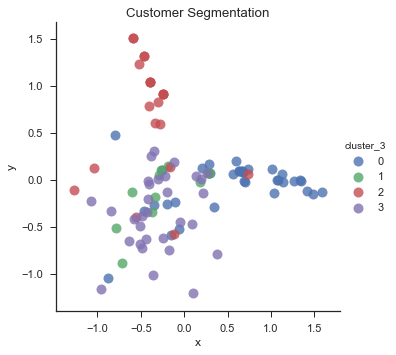

In [37]:
sns.lmplot('x', 'y',
           data=customer_clusters,
           fit_reg=False,
           hue='cluster_3',  
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('Customer Segmentation')
plt.xlabel('x')
plt.ylabel('y')

# The Iterative Process <a id='general'></a>

In [38]:
mus, Sigmas, phi = GM.train(data, mus, Sigmas, phi, niters = 150, reg=1e-4)
ps = GM.Estep(data, mus, Sigmas, phi)
cluster_final = np.argmax(ps, axis = 1)
matrix['cluster_final'] = cluster_final
customer_clusters = matrix[['customer_name', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_final','x', 'y']]
print customer_clusters.cluster_final.value_counts()
customer_clusters.head()

0    36
3    31
2    21
1    12
Name: cluster_final, dtype: int64


offer_id,customer_name,cluster_1,cluster_2,cluster_3,cluster_final,x,y
0,Adams,0,0,0,0,1.007580,0.108215
1,Allen,1,1,1,1,-0.287539,0.044715
2,Anderson,2,2,2,2,-0.392032,1.038391
3,Bailey,3,0,0,0,0.699477,-0.022542
4,Baker,3,3,3,3,0.088183,-0.471695


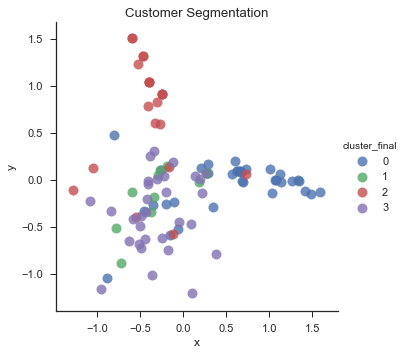

In [39]:
sns.lmplot('x', 'y',
           data=customer_clusters,
           fit_reg=False,
           hue='cluster_final',  
           scatter_kws={"marker": "D",
                        "s": 100})
plt.title('Customer Segmentation')
plt.xlabel('x')
plt.ylabel('y')

# Additional Analysis of Clusters and Business Findings <a id='business'></a>

In [40]:
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)
df.head()

,offer_id,campaign,product_type,level_emphasis_premium_savings,level_emphasis_neighborhood_agent,customer_name,n,cluster_1,cluster_2,cluster_3,cluster_final,x,y
0,1,January,Product 1,7,5,Thomas,1,0,2,2,2,-1.041879,0.122314
1,1,January,Product 1,7,5,Jackson,1,3,3,3,3,-0.839578,-0.328823
2,1,January,Product 1,7,5,Mitchell,1,3,3,3,3,-0.342938,0.302186
3,1,January,Product 1,7,5,Peterson,1,0,0,0,0,-0.797379,0.475995
4,1,January,Product 1,7,5,Wood,1,3,2,2,2,-0.551215,-0.395670


In [41]:
df['is_0'] = df.cluster_final==0
print df.groupby("is_0").product_type.value_counts()


is_0   product_type
False  Product 4       66
       Product 2       42
       Product 5       26
       Product 7       24
       Product 1       15
       Product 3       14
       Product 6       13
       Product 8       13
True   Product 3       26
       Product 7       19
       Product 1       17
       Product 9       17
       Product 4       15
       Product 8        7
       Product 5        6
       Product 2        2
       Product 6        2
Name: product_type, dtype: int64


In [43]:
print df.groupby("is_0")[['level_emphasis_premium_savings', 'level_emphasis_neighborhood_agent']].mean()
print df.groupby("is_0")[['level_emphasis_premium_savings', 'level_emphasis_neighborhood_agent']].median() #group 0 likes offers with smaller quantities

       level_emphasis_premium_savings  level_emphasis_neighborhood_agent
is_0                                                                    
False                        6.051643                           5.436620
True                         2.261261                           5.513514
       level_emphasis_premium_savings  level_emphasis_neighborhood_agent
is_0                                                                    
False                               7                                  5
True                                0                                  5


In [45]:
df['is_1'] = df.cluster_final==1
print df.groupby("is_1").product_type.value_counts()  

is_1   product_type
False  Product 4       70
       Product 2       44
       Product 7       42
       Product 3       35
       Product 1       31
       Product 5       31
       Product 8       18
       Product 9       17
       Product 6        7
True   Product 4       11
       Product 6        8
       Product 3        5
       Product 8        2
       Product 1        1
       Product 5        1
       Product 7        1
Name: product_type, dtype: int64


In [46]:
print df.groupby("is_1")[['level_emphasis_premium_savings', 'level_emphasis_neighborhood_agent']].mean()
print df.groupby("is_1")[['level_emphasis_premium_savings', 'level_emphasis_neighborhood_agent']].median() #nothing too significant, one order must have skewed the mean

       level_emphasis_premium_savings  level_emphasis_neighborhood_agent
is_1                                                                    
False                        4.515254                           5.454237
True                         7.172414                           5.551724
       level_emphasis_premium_savings  level_emphasis_neighborhood_agent
is_1                                                                    
False                               7                                  5
True                                7                                  5


In [47]:
df['is_2'] = df.cluster_final==2
print df.groupby("is_2").product_type.value_counts() 

is_2   product_type
False  Product 4       74
       Product 7       39
       Product 3       36
       Product 1       29
       Product 5       27
       Product 9       17
       Product 8       16
       Product 6       13
       Product 2        7
True   Product 2       37
       Product 4        7
       Product 5        5
       Product 3        4
       Product 7        4
       Product 8        4
       Product 1        3
       Product 6        2
Name: product_type, dtype: int64


In [48]:
print df.groupby("is_2")[['level_emphasis_premium_savings', 'level_emphasis_neighborhood_agent']].mean()
print df.groupby("is_2")[['level_emphasis_premium_savings', 'level_emphasis_neighborhood_agent']].median() #nothing too significant, care about discount a little less

       level_emphasis_premium_savings  level_emphasis_neighborhood_agent
is_2                                                                    
False                        4.589147                           5.542636
True                         5.393939                           5.151515
       level_emphasis_premium_savings  level_emphasis_neighborhood_agent
is_2                                                                    
False                               7                                  5
True                                7                                  5


In [49]:
df['is_3'] = df.cluster_final==3
print df.groupby("is_3").product_type.value_counts() 

is_3   product_type
False  Product 2       39
       Product 3       35
       Product 4       33
       Product 7       24
       Product 1       21
       Product 9       17
       Product 8       13
       Product 5       12
       Product 6       12
True   Product 4       48
       Product 5       20
       Product 7       19
       Product 1       11
       Product 8        7
       Product 2        5
       Product 3        5
       Product 6        3
Name: product_type, dtype: int64


In [50]:
print df.groupby("is_3")[['level_emphasis_premium_savings', 'level_emphasis_neighborhood_agent']].mean()
print df.groupby("is_3")[['level_emphasis_premium_savings', 'level_emphasis_neighborhood_agent']].median() #buys larger quantities

       level_emphasis_premium_savings  level_emphasis_neighborhood_agent
is_3                                                                    
False                        3.956311                           5.402913
True                         6.144068                           5.567797
       level_emphasis_premium_savings  level_emphasis_neighborhood_agent
is_3                                                                    
False                               1                                  5
True                                7                                  5


# Applications for Other Domains<a id='other'></a>

Market segmentation for the financial sector

Anomaly detection of transactions

News clustering (TF-IDF)

Medical image segmentation

etc.


# Sources<a id='sources'></a>

http://blog.yhat.com/posts/customer-segmentation-using-python.html

http://ieeexplore.ieee.org/document/1633722/?reload=true

http://www.nature.com/nbt/journal/v26/n8/full/nbt1406.html#f1

https://www.researchgate.net/post/How_does_GMM_work_in_principle  

http://datasciencecourse.org/anomaly_detection.pdf 

http://cs229.stanford.edu/notes/cs229-notes8.pdf 
